# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#use this cell to import additional libraries or define helper functions
import datetime
from sklearn.metrics import mean_squared_error as mse

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [3]:
#Load your data into a pandas dataframe here
df = pd.read_csv("household_power_clean.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [4]:
#convert datetime to epoch/unix time
df['unix'] = df['Datetime'].apply(lambda x: int(x.timestamp()))

## Predicting Global Active Power

We will follow the code from the Chapter 10 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: "mu" is a parameter that governs the magnitude of each step in the gradient descent process. This process is used to optimize the model parameters for better performance.
Here "ph" specifies the duration in seconds for which we aim to generate predictions. In this particular instance, "ph" is assigned a value of 5 minutes or 300 seconds, indicating that the prediction model is designed to make forecasts for a 5-minute duration.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [24]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5*60
value = df.unix[1] - df.unix[0]
ph_index = int(ph/value)
mu = 0.01

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: From the calculations it would be around 4.82e-13

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [25]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]
    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i][0]
    yp = m_tmp*tp + q_tmp

    tp_pred[i-2] = tp 
    yp_pred[i-2] = yp

Now let's visualize the results from our model.

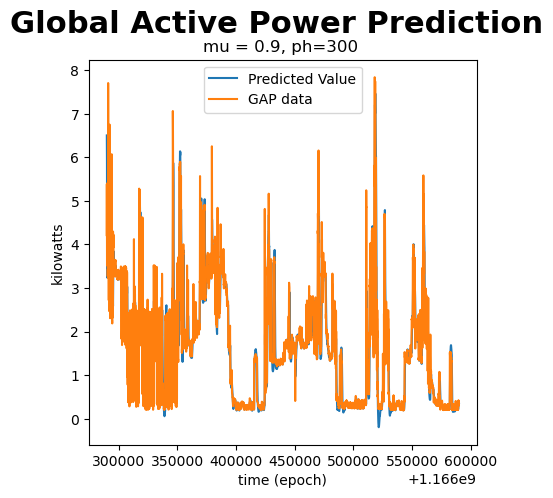

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

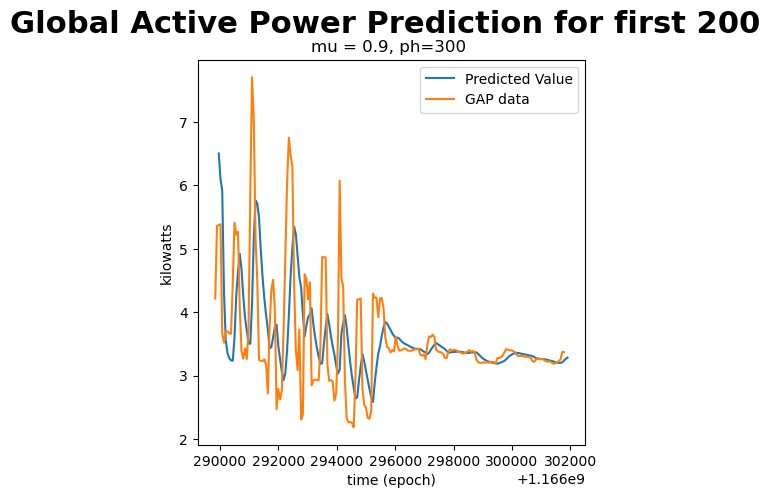

In [15]:
#Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Global Active Power Prediction for first 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

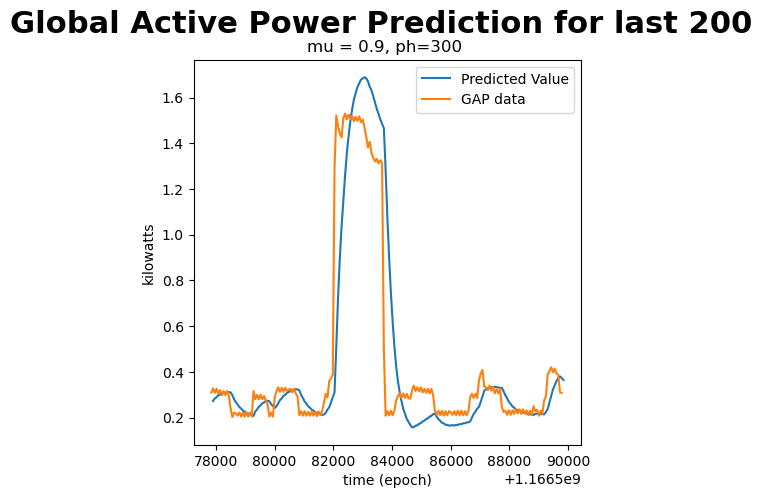

In [16]:
#Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Global Active Power Prediction for last 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [17]:
#Calculate MSE of predictions
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.5320095734013462


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The graphical plots represent that the model's predictions are mostly accurate, as they tend to follow the trend of the actual values. However, the model struggles to predict the outlier values in the dataset. Moreover, there seems to be a noticeable discrepancy between early and late predictions, with earlier predictions (first 200 data points) being more precise than the later ones (last 200 data points). This could be due to the model's linear regression approach, which may not fully capture the non-linear relationships present in the data.

Regarding the charts, it can be observed that the predicted values exhibit minor variations compared to the Global Active Power (GAP) values, and the shapes of the two graphs are almost identical. Furthermore, the graph displays that the GAP values initially produce more kilowatts than the predicted values, but towards the end, the predicted values produce more kilowatts.

The Mean Squared Error (MSE) metric confirms that the model performs well, as the predicted values are reasonably close to the actual values.


**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

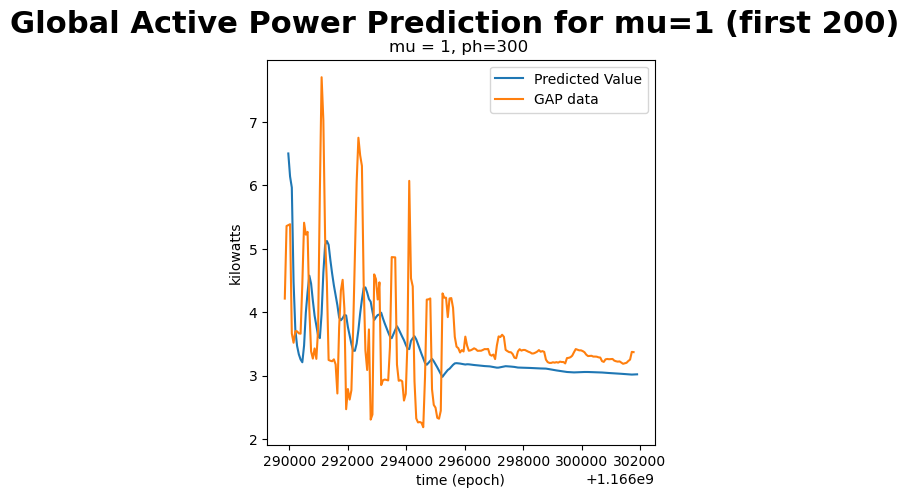

In [21]:
#Plot first 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Global Active Power Prediction for mu=1 (first 200)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

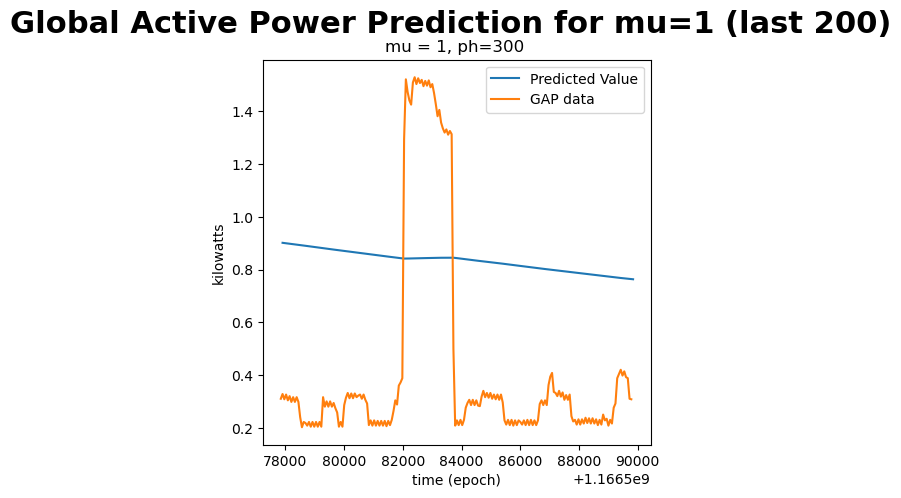

In [22]:
#Plot last 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Global Active Power Prediction for mu=1 (last 200)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


In [23]:
#Calculate MSE of predictions for mu = 1
print("MSE predictions for mu = 1 is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE predictions for mu = 1 is 1.4205800805943645


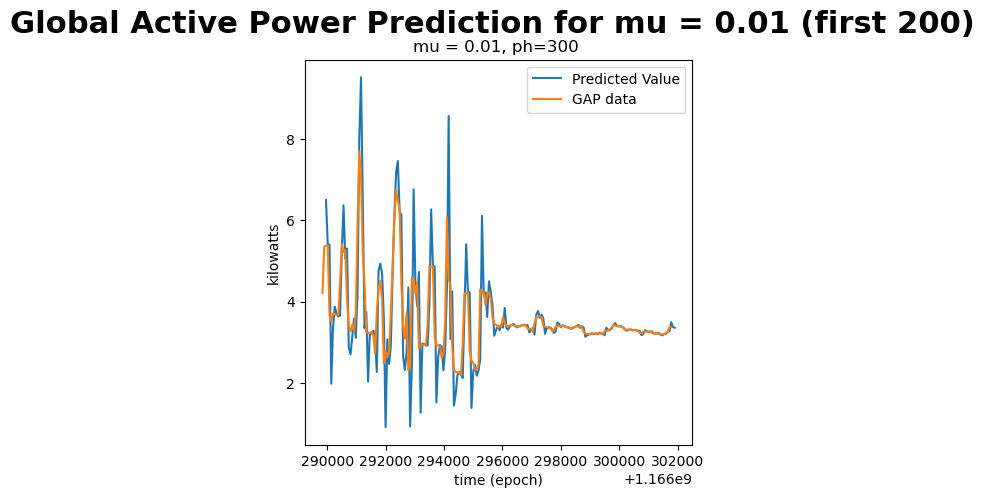

In [26]:
#Plot first 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Global Active Power Prediction for mu = 0.01 (first 200)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

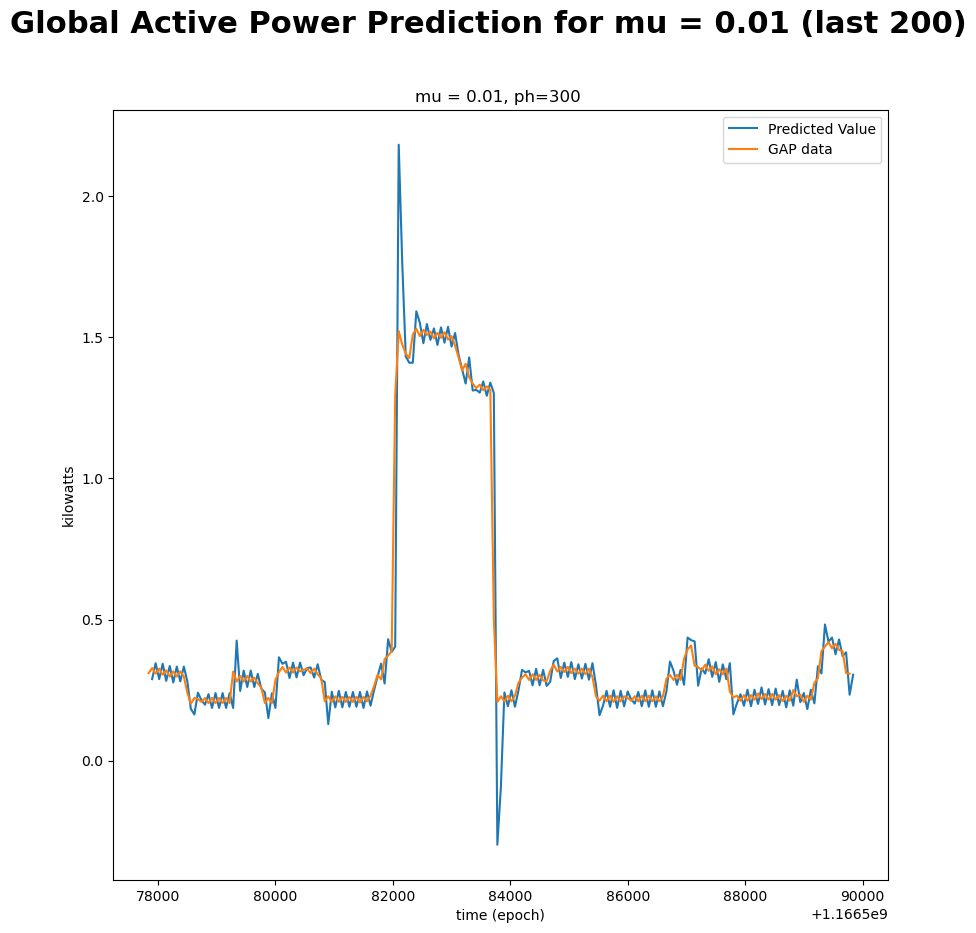

In [27]:
#Plot last 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction for mu = 0.01 (last 200)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


In [28]:
#Calculate MSE of predictions for mu = 0.01
print("MSE predictions for mu = 0.01 is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))


MSE predictions for mu = 0.01 is 1.0941503055098398


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: When mu is set to 1, the graphical plots indicate that the model performs well for the first 200 predictions, with predicted values closely following the trend of the actual Global Active Power (GAP) values. However, for the last 200 predictions, there is a visible discrepancy between the predicted and actual GAP values. This indicates that the model faces difficulties in capturing longer-term trends in the data and instead concentrates too much on short-term variations, which results in overfitting.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: When mu is set to 0.01, the graphical plots indicate that for both the first and last 200 predictions, the predicted values consistently generate more kilowatts than the actual Global Active Power (GAP) values. Nonetheless, the shapes of the graphs for the predicted values and the actual GAP values are similar.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: considering MSE for the three models we can say the first model appers to be the best

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: Currently, the model utilizes a linear regression strategy, which may not accurately capture non-linear relationships in the data. Incorporating non-linear regression techniques such as polynomial regression or using neural networks could potentially improve the accuracy of the model.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [29]:
#add voltage to the x-variables in our dataset
list = {'unix': df.unix, 'voltage': df.Voltage}
ts =  pd.DataFrame(list)
ys = pd.DataFrame(df.Global_active_power)

ph = 5*60
ph_index = (int)(ph/60)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [30]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage
for i in range(2, n_s+1):
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    weights = np.ones(ns)*mu
    for k in range(ns):
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]
    m_voltage = model_tmp.coef_[0][1]
    q_voltage=0
    tp = ts.iloc[i][0]
    voltage = ts_tmp.voltage*m_voltage
    yp = m_tmp*tp + q_tmp + voltage[1] + q_voltage
    tp_pred[i-2] = tp 
    yp_pred[i-2] = yp

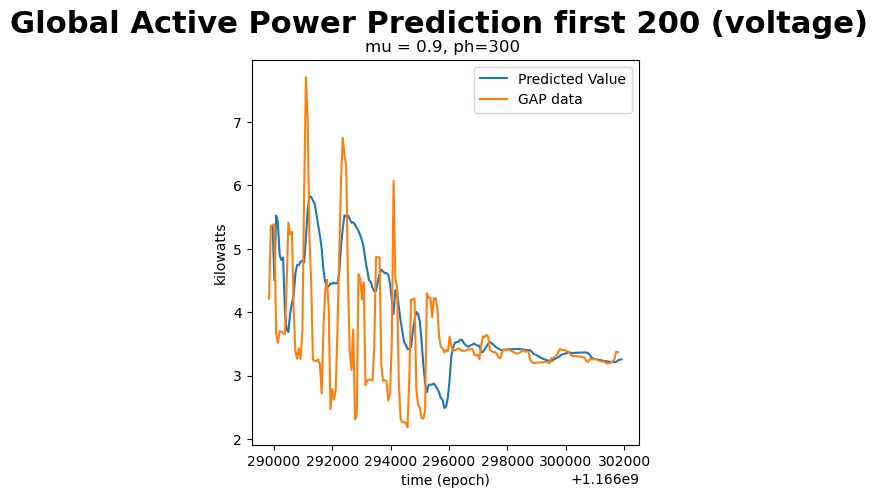

In [31]:
#Plot first 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Global Active Power Prediction first 200 (voltage)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

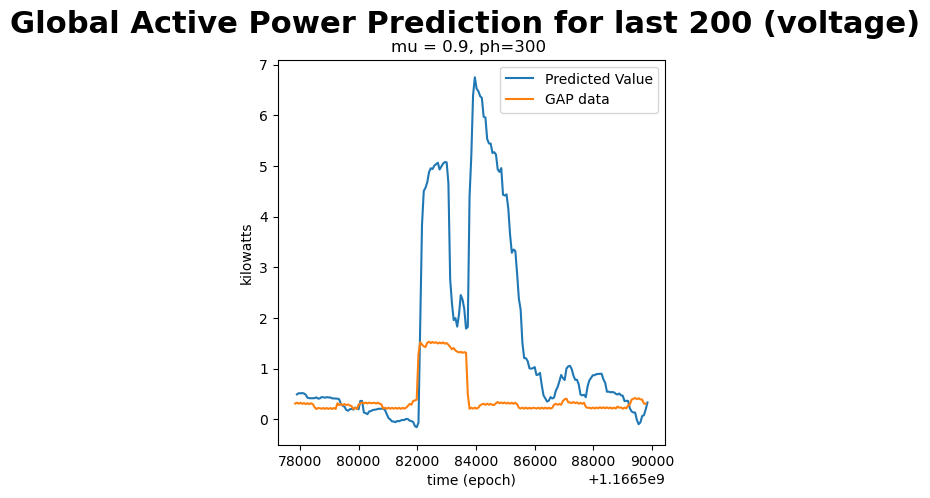

In [32]:
#Plot last 200 data points/predictions for the expanded data
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Global Active Power Prediction for last 200 (voltage)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [33]:
#Calculate MSE of predictions for the expanded data
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 5.87426830477987


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: Introducing voltage data as an additional variable to the model does not guarantee an improvement in its performance, and it's essential to consider the specific problem and data at hand. To evaluate the model's effectiveness, the Mean Squared Error (MSE) of its predictions can be computed. To enhance the model's performance using linear regression, there are numerous alternative methods that can be explored.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**
I propose an alternative model that employs a moving average as the response variable, rather than using the actual global active power values. The moving average is calculated by taking the average of the previous n values (where n is a hyperparameter) in a rolling window at each time point, which is then used for prediction.
There are multiple reasons why this alternative model could outperform the original one. Firstly, the use of a moving average can help to reduce the noise and impact of outliers in the data, leading to more stable and accurate predictions. Secondly, incorporating a moving average as the response variable can capture longer-term trends in the data that may be overlooked by the original model, which focuses only on short-term fluctuations. Lastly, the rolling window approach may be simpler to explain to stakeholders who lack familiarity with the underlying math compared to a weighted regression using a mu factor.

In [34]:
n = 10 # hyperparameter for moving average window size
y_ma = df['Global_active_power'].rolling(window=n).mean().shift(-n+1)

y_ma = y_ma.dropna()

x = df[['unix', 'Voltage']]

x = x.iloc[n-1:-1]

data = pd.concat([x, y_ma], axis=1)
ph = 5 * 60
ph_index = int(ph / 60)
mu = 0.9

n_s = 5000

tp_pred = np.zeros(n_s - 1)
yp_pred = np.zeros(n_s - 1)

In [35]:

for i in range(n, n + n_s - 1):
    x_tmp = data.iloc[i - n:i, :-1]
    y_tmp = data.iloc[i - n:i, -1:]
    ns = len(y_tmp)

    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = weights[k] ** k
    weights = np.flip(weights, 0)

    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(x_tmp, y_tmp, sample_weight=weights)

    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]
    m_voltage = model_tmp.coef_[0][1]
    q_voltage = 0

   
    tp = data.iloc[i, 0]
    voltage = x_tmp.iloc[-1, 1] * m_voltage
    yp = m_tmp * tp + q_tmp + voltage + q_voltage
    tp_pred[i - n] = tp
    yp_pred[i - n] = yp

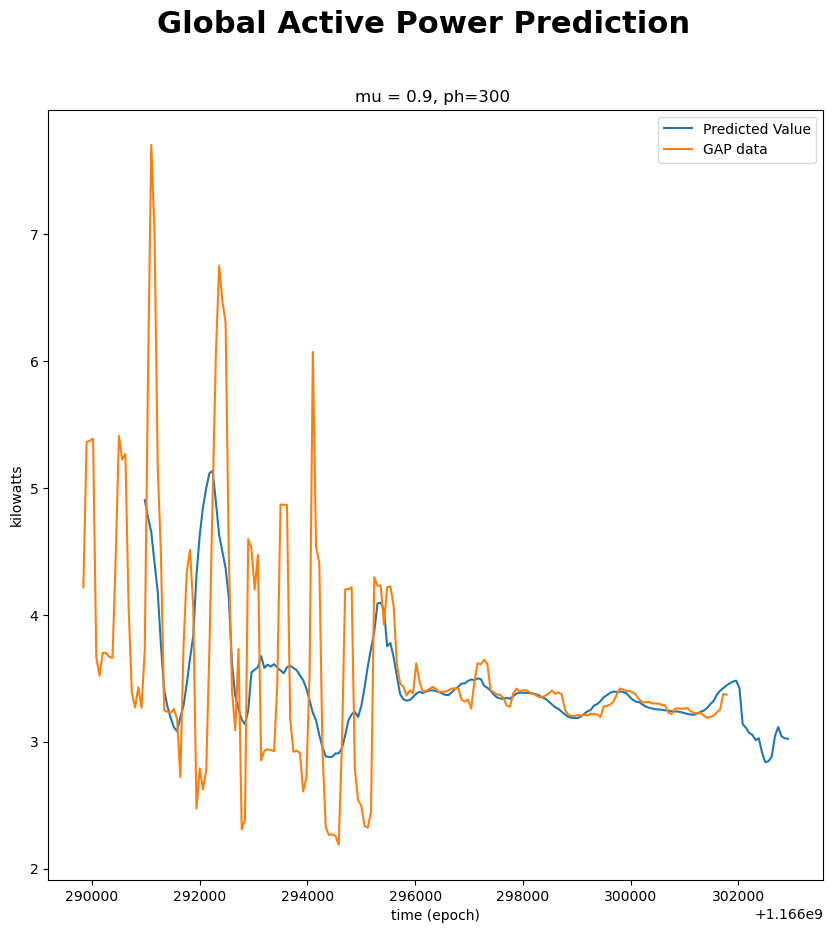

In [36]:
#Plot first 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

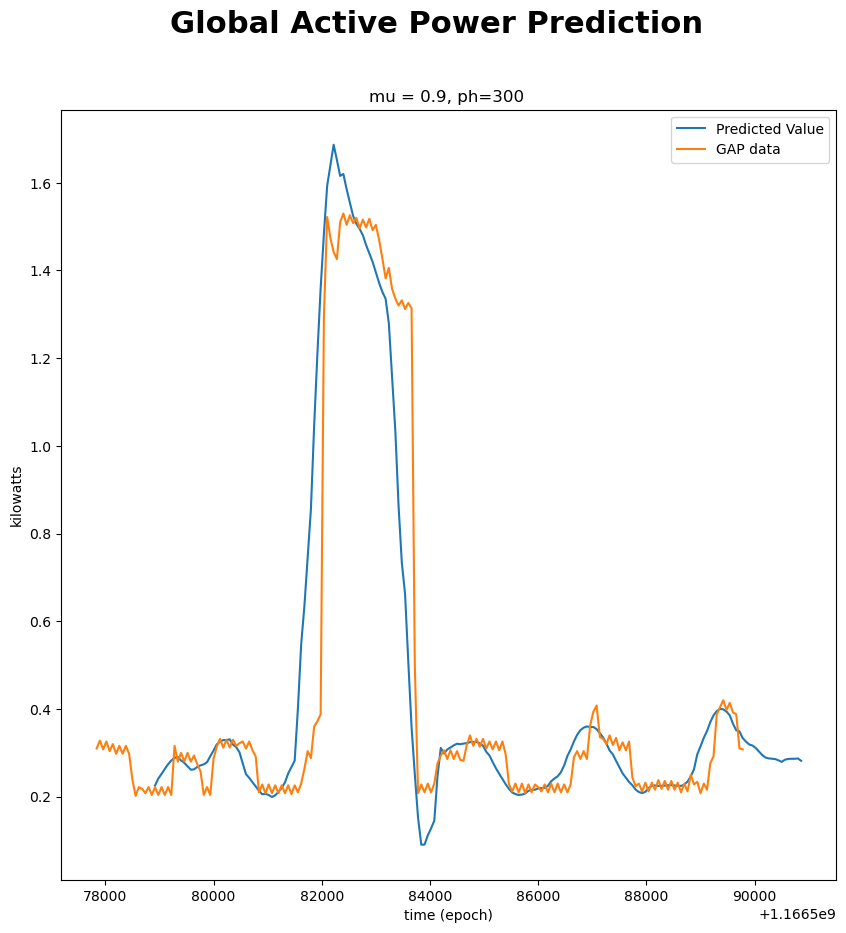

In [37]:
#Plot last 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [38]:
#Calculate MSE of predictions for alternative model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(ys[1:n_s], yp_pred)
print(mse)

1.1133907951300615


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A:
It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.